In [1]:
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.image as mpimg 
import torch
import SimpleITK as sitk
from scipy.ndimage.interpolation import zoom
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

汽车样本数量： 8792
非汽车样本数量： 8968


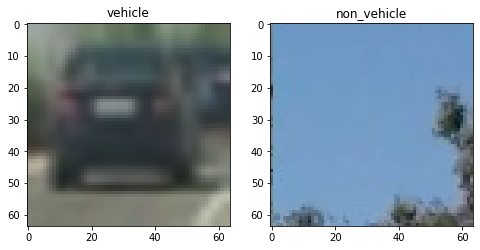

In [3]:

vehicle_lable = 1
non_vehicle_label = 0

# 读入数据
vehicles_file_paths = glob.glob("./vehicles/*/*.png")
non_vehicles_file_paths = glob.glob("./non-vehicles/*/*.png")
print("汽车样本数量：" , len(vehicles_file_paths))
print("非汽车样本数量：" , len(non_vehicles_file_paths))

# 显示汽车和非汽车图片
vehicle_img = mpimg.imread(vehicles_file_paths[0])
non_vehicle_img = mpimg.imread(non_vehicles_file_paths[0])
fig, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(8, 20))
ax1.imshow(vehicle_img)
ax1.set_title("vehicle")
ax2.imshow(non_vehicle_img)
ax2.set_title("non_vehicle")
plt.show()

## 对图像进行resize以便可以输入网络

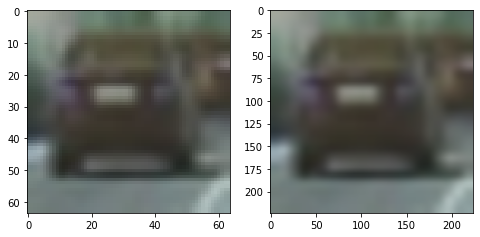

In [4]:
img = cv2.imread(vehicles_file_paths[0])
img1 = cv2.resize(img,(224,224))
fig, (ax1,ax2) = plt.subplots(1, 2 ,figsize=(8, 20))
ax1.imshow(img)
ax2.imshow(img1)
plt.show()

In [5]:
X = []
y = []
for path in vehicles_file_paths[0:1000]:
    img = cv2.imread(path)
    img1 = cv2.resize(img,(224,224))
    X.append(img1)
    y.append(vehicle_lable)

for path in non_vehicles_file_paths[0:1000]:
    img = cv2.imread(path)
    img1 = cv2.resize(img,(224,224))
    X.append(img1)
    y.append(non_vehicle_label)

In [6]:
X_train = torch.tensor(X).float()
y_train = torch.tensor(y).float()
X_train = torch.transpose(X_train,1,3)


In [7]:
X_train = X_train.to(device)
y_train = y_train.to(device)

In [9]:
X_train = torch.transpose(X_train,2,3)

In [10]:
print(X_train.shape)
print(y_train.shape)

torch.Size([2000, 3, 224, 224])
torch.Size([2000])


In [12]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [14]:
model = AlexNet()
model.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU(inplace)
    (4

In [15]:
lr = 1e-5
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [16]:
for epoch in range(100):
    print('epoch {}'.format(epoch))

    train_loss = 0.0
    trian_acc = 0.0

    optimizer.zero_grad()
    X = Variable(X_train.cuda())
    y = Variable(y_train.cuda())
    with torch.no_grad():
        y_ = model(X)

    loss = loss_func(y_, y)
    train_loss += loss.data[0]

    pred = torch.max(y_, 1)[1]
    # 返回最大值的索引
    train_correct = (pred == y).sum()
    trian_acc += train_correct[0]

    loss.backward()
    optimizer.step()

    print('loss : {:.6f}, ACC : {:.6f}'.format(train_loss/len(trainSet), trian_acc))

epoch 0


RuntimeError: CUDA out of memory. Tried to allocate 1.12 GiB (GPU 0; 2.00 GiB total capacity; 1.33 GiB already allocated; 31.04 MiB free; 13.68 MiB cached)

## 测试部分

In [14]:
img_test = X_train[1]

In [15]:
img_test.shape

torch.Size([3, 224, 224])

In [16]:
y_test = model(img_test)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 3 11, but got 3-dimensional input of size [3, 224, 224] instead